## Hierarchical Bayesian Modeling to assess tribal knowledge

Our aim with this analysis is to create a methodology and a set of data-driven metrics that can help us identify potential technological risks within an organization's IT landscape. This proof of concept focuses on various risk factors that could affect operational health and security and influence technical debt hidden in our IT landscape. These metrics provide a quantitative basis for a risk diagnostic and enable us to see the impact of making directly relevant choices to reducing these risks. 

For our analysis, we focus on 7 major factors and rationale as to why:

  - **Time Since Last Commit**: This metric indicates the recency of activity within a repository. Longer intervals since the last commit can suggest a project becomes dormant, highlighting potential maintenance or abandonment risks.
  - **Age of the Repo**: his metric reflects the age of the repository from its initial creation to the present day. While a newer repository might be in active development or just gaining traction, an older repository with sporadic updates may indicate a legacy system that's either stable with minimal changes needed or potentially neglected.
  - **Commit Frequency (CF)**: Regular commit activity shows ongoing development and maintenance. Low commit frequency can signal reduced development efforts or potential stagnation, implying operational risks.
  - **Open Issues Ratio (OIR)**: The ratio of open to closed issues offers insights into how effectively a project addresses bugs, requests, or security concerns. A high open issues ratio may indicate operational inefficiencies or backlogs that could escalate into security or functional risks.
  - **Pull Request Resolution Time (PRRT)**: The average time to close pull requests reflects the project's responsiveness and process efficiency. Longer resolution times may indicate bottlenecks in the development process, affecting the project's ability to respond promptly to emerging risks.
  - **Total Number of Languages in the Repo**: Projects utilizing a wide range of programming languages might face increased complexity, potentially raising the risk of integration issues, maintenance challenges, and a higher barrier for new contributors, which could affect long-term sustainability.
  - **Average Number of Commits per Month**: This metric provides an average rate of development activity over time, offering a more granulated view of the project's momentum. A declining trend may indicate a loss of development interest or a shift in focus, which could affect the project's vitality and risk profile.

### Composite Function and Problem-Solving Capability

When combined mathematically, the metrics above create a composite function that assesses risk across multiple dimensions. The model provides a comprehensive view of each repository's risk profile by combining these factors. This approach enables:

- **Prioritization of Risk Mitigation Efforts**: Repositories or projects exhibiting higher risk signals across these metrics can be prioritized for further investigation and remediation efforts.
- **Early Warning System:** Trends identified through these metrics can serve as early warnings for projects heading towards higher-risk states, allowing proactive interventions.
- **Strategic Decision Support**: By understanding the risk landscape across the IT estate, decision-makers can make informed strategic choices about resource allocation, project continuation, and architectural adjustments.

To understand the dynamics of these risks, we utilise Hierarchical Bayesian Modelling (HBM) as our analytical tool. HBM is adept at handling multi-level data, enabling us to dissect the layers of risk present in individual repositories and across the organisation as a whole.  For instance, a decline in commit activity and an increase in outdated dependencies may indicate a repository becoming less active or potentially being deprecated.  Conversely, a consistent or improving security posture alongside these trends might indicate a repository reaching a stage of maturity, requiring fewer updates.  

#### Flow

We extract key risk metrics through the GitHub REST API to construct a hierarchical Bayesian model for assessing risk. These metrics are crucial for creating and understanding compound metrics for our repositories' operational and security risks.

**Data Collection and Preparation:** The initial step involves fetching and transforming data to construct these risk indicators across all repositories and owners via the GitHub API. This forms the base of our dataset, capturing a wide range of activities and potential vulnerabilities across the software development process.

**Model Construction:** Using PyMC, we then define a hierarchical model that mirrors the layered nature of our data. This model distinguishes the variability within individual repositories and the typical patterns observable across different owners. By affecting repository-level distributions through owner-level priors, the model aims to uncover both specific and general risk trends.

**Hierarchical Model Framework:**
- **Level 1 (Observations):** Integrates base metrics as the observable layer.
- **Level 2 (Risk Factors):** Introduces latent variables for different risk types (Operational health, Technical Debt) influenced by the Level 1 metrics.
- **Level 3 (Overall Risk):** Our model aggregates the Level 2 risk factors into a compound risk score, reflecting the overall risk impact on the IT estate.

**Inference and Analysis:** We sample from the posterior distribution by applying PyMC's MCMC methods to refine our model parameters. This allows us to investigate the posterior distributions and identify which languages or practices significantly deviate from the norm, marking them as potential risk areas.

This approach enables a structured exploration of how various risk components interact and influence the overall risk landscape. PyMC's flexibility facilitates scenario simulation, such as evaluating the impact of improving pull request resolution time (PRRT) on the overall risk. This rigorous analysis gives us detailed insights into our IT estate's risk profile, supporting strategic decision-making and focused risk mitigation efforts.

In [57]:
# Import required packages

import pandas as pd
import numpy as np
import pymc as pm
import random 
import arviz as az
import subprocess 
import pprint 
import os

from datetime import datetime
from time import sleep
from dateutil.relativedelta import relativedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from ridgeplot import ridgeplot
from dotenv import load_dotenv

from tribal_knowledge.utils import LanguagePosteriorAnalysis, save_with_joblib, load_with_joblib
from tribal_knowledge.repo_crawler import GitHubRepositoryInfoExtractor, PandasOutputFormat
from github import Github, RateLimitExceededException
from github.PaginatedList import PaginatedList
from github.StatsCommitActivity import StatsCommitActivity
from github.StatsParticipation import StatsParticipation

## Data Collection

We have enabled two options to get data, 
  * Option 1: Using dummy data - This data is a copy of some data from the GitHub REST service and processed to have the same output as the data from the `RepoCrawler` class for the OWNER Apache.
  * Option 2: We use the `RepoCrawler` class to pull data, and fields of interest are left to the user to define. This option requires a user to set a GitHub token.

To use the second option, a personal access token must be given to the RepoCrawler (https://docs.github.com/en/enterprise-server@3.9/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens)


In [58]:
# Attempt to get the value of GITHUB_API_TOKEN environment variable - USER must set this either as global env var or you can set in a .env file
load_dotenv('.env')
github_api_token = os.environ.get('GITHUB_API_TOKEN')

if github_api_token:
    print("GITHUB_API_TOKEN retrieved")
else:
    print("GITHUB_API_TOKEN is not set.")

GITHUB_API_TOKEN retrieved


Depending on whether we receive a token, we will fetch data from a specified repository or load the dummy data. In this example, we will parse the Apache Foundation GitHub repository, which has around 3,000 repositories, and retrieve the programming language bytes and the number of stargazers for each repository.

We've selected made use of the REST API in order to receive data for understanding the various dimensions of risk across repositories:

To calculate *Commit Frequency* (CF) and *Average Number of Commits per Month*, we utilise the `get_stats_commit_activity` method. This method fetches data on commit activity over the past year, providing a basis for assessing repository maintenance and development momentum.

*Time Since Last Commit* is inferred from the latest activity data obtained via `get_stats_participation`. While this method offers a broad stroke of engagement, pinpointing the exact date of the last commit may require calculation on the timestamps.

The *Open Issues Ratio* (OIR) calculation relies on data from `get_issues` with the state set to "open". Completing this metric's calculation requires additional processing to contrast open against closed issues.

*Pull Request Resolution Time* (PRRT) is determined by analysing data from `get_pulls` with the state as "all". This involves calculating the duration between the creation and closure of pull requests, which tells us the efficiency of the project's review and integration processes.

The *Total Number of Languages* in the Repo is directly fetched using `get_languages`, offering insights into the project's complexity and the diversity of its technological stack.

In [59]:
# We have saved the output of getting the full set of repo details in ./data/apache_repos.json to eliminate the need to make the API calls
# To update this list, change rerun = True and delete the existing file

random.seed(42)
rerun = False
data_file = "./data/apache_repos.joblib"
owners = ['apache']  # Specify the GitHub owners from whom to fetch repositories
details_spec = {
    "properties": ["created_at"], 
    "methods": { 
        "get_stats_commit_activity": {},
        "get_stats_participation": {},
        "get_issues": {"state": "all"},
        "get_pulls": {"state": "all"},
        "get_languages": {}
    }
}

# Check if rerun is required or file doesn't exist
if rerun or not os.path.exists(data_file):
    if github_api_token:
        try:
            with GitHubRepositoryInfoExtractor(access_token=github_api_token, max_workers=1) as extractor:
                repos = extractor.fetch_repositories(identifiers=owners)
                # Fetch repository details
                # Getting a random selection of 250 repositories
                selected_repos = random.sample(repos, 250)
                repo_attributes = extractor.fetch_repository_details(repos=selected_repos, details_spec=details_spec)
                # Save to file using the save_json function
                save_with_joblib(repo_attributes, data_file)
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print("GITHUB_API_TOKEN is not set. Please set it to proceed.")
else:
    # Load from a file if rerun is False and file exists
    try:
        repo_attributes = load_with_joblib(data_file)
        print(f"Repository details loaded from {data_file}.")
    except FileNotFoundError as e:
        print(e)


Repository details loaded from ./data/apache_repos.joblib.


GitHub's API methods through PyGithub are successful; the raw objects returned by these calls are directly stored in the results dictionary. This is typical behaviour when working with PyGithub, as the library returns specialised objects for API responses, which include paginated lists for iterable results (like issues or pull requests) and custom objects for structured data (like commit activities or language statistics).

Let's unpack these to be a little more useful

In [60]:
def count_paginated_items(paginated_list, condition=lambda x: True):
    """Count items in a PaginatedList that meet the given condition."""
    return sum(1 for item in paginated_list if condition(item))

def process_repository_details(repo_name, repo_data):
    processed_data = {}
    
    # Handle created_at date
    if "created_at" in repo_data:
        created_at = repo_data["created_at"]
        current_date = datetime.now(created_at.tzinfo)
        age_days = (current_date - created_at).days
        processed_data["age_in_days"] = age_days

    # Handle languages
    if "get_languages" in repo_data:
        languages = repo_data.get("get_languages", {})
        total_bytes = sum(languages.values())
        total_languages = len(languages.keys())
        processed_data["total_language_bytes"] = total_bytes
        processed_data["total_languages"] = total_languages

    # Handling issues
    if "get_issues" in repo_data:
        if isinstance(repo_data["get_issues"], PaginatedList):
            issues = repo_data["get_issues"]
            open_issues_count = count_paginated_items(issues, condition=lambda x: x.state == "open")
            closed_issues_count = count_paginated_items(issues, condition=lambda x: x.state == "closed")
            total_issues = open_issues_count + closed_issues_count
            open_issues_ratio = open_issues_count / total_issues if total_issues > 0 else 0
            processed_data["open_issues_ratio"] = open_issues_ratio
            processed_data["open_issues_count"] = open_issues_count
            processed_data["closed_issues_count"] = closed_issues_count
            # Deleting 'get_issues' object after processing for space
            del repo_data["get_issues"]

    # Handling pulls 
    if "get_pulls" in repo_data:
        if isinstance(repo_data["get_pulls"], PaginatedList):
            pulls = repo_data["get_pulls"]
            merged_pulls_count = sum(1 for pull in pulls if pull.merged_at is not None)
            processed_data["merged_pulls_count"] = merged_pulls_count
            # Deleting 'get_pulls' after processing
            del repo_data["get_pulls"]

    # Handling commit 
    if "get_stats_commit_activity" in repo_data:
        if isinstance(repo_data["get_stats_commit_activity"], list):
            commit_activity = repo_data["get_stats_commit_activity"]
            total_commits_last_year = sum(activity.total for activity in commit_activity)
            processed_data["total_commits_last_year"] = total_commits_last_year
            # Deleting 'get_stats_commit_activity' after processing
            del repo_data["get_stats_commit_activity"]
            
    # Handling participation
    if "get_stats_participation" in repo_data:
        if isinstance(repo_data["get_stats_participation"], StatsParticipation):
            participation = repo_data["get_stats_participation"]
            total_commits = sum(participation.all)
            processed_data["total_commits_participation"] = total_commits
            # Deleting 'get_stats_participation' after processing
            del repo_data["get_stats_participation"]
            

    return repo_name, processed_data


def process_all_repositories(repo_attributes, max_workers=1):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_repo = {executor.submit(process_repository_details, repo_name, repo_data): repo_name for repo_name, repo_data in repo_attributes.items()}
        progress = tqdm(as_completed(future_to_repo), total=len(repo_attributes), desc="Processing Repositories")

        for future in progress:
            repo_name = future_to_repo[future]
            try:
                _, processed_data = future.result()
                repo_attributes[repo_name].update(processed_data)
            except Exception as exc:
                print(f'{repo_name} generated an exception: {exc}')
                
    return repo_attributes

In [61]:
# Let us process things - again, we have built-in multi-threading for speed if required. However, watch the API rate limits of Github 
# We have saved a copy of this data in /data/processed_repo_attributes.json for convenience 

processed_data_file = './data/apache_repo_attributes.joblib'

# Check if we need to rerun processing or load existing data
if not os.path.exists(processed_data_file):
    # Assuming `process_all_repositories` is a function that processes your data
    repo_attributes = process_all_repositories(repo_attributes, max_workers=2)
    
    # Save processed data using the generic save function
    save_with_joblib(repo_attributes, processed_data_file)
else:
    # Load the repository details from the file using the generic load function
    repo_attributes = load_with_joblib(processed_data_file)
    print(f"Repository details successfully read from {processed_data_file}.")

Repository details successfully read from ./data/apache_repo_attributes.joblib.


In [62]:
pprint.pprint(list(repo_attributes.items())[:5])


[('apache/cordova-plugin-statusbar',
  {'age_in_days': 3669,
   'closed_issues_count': 232,
   'created_at': datetime.datetime(2014, 3, 15, 7, 0, 7, tzinfo=datetime.timezone.utc),
   'get_languages': {'Java': 8815, 'JavaScript': 9709, 'Objective-C': 17298},
   'merged_pulls_count': 82,
   'open_issues_count': 29,
   'open_issues_ratio': 0.1111111111111111,
   'total_commits_last_year': 8,
   'total_commits_participation': 8,
   'total_language_bytes': 35822,
   'total_languages': 3}),
 ('apache/ant-antlibs-s3',
  {'age_in_days': 761,
   'closed_issues_count': 0,
   'created_at': datetime.datetime(2022, 3, 1, 4, 25, 20, tzinfo=datetime.timezone.utc),
   'get_languages': {'Java': 258102},
   'merged_pulls_count': 0,
   'open_issues_count': 0,
   'open_issues_ratio': 0,
   'total_commits_last_year': 0,
   'total_commits_participation': 0,
   'total_language_bytes': 258102,
   'total_languages': 1}),
 ('apache/incubator-seata-go',
  {'age_in_days': 1451,
   'closed_issues_count': 601,
   '

## Hierarchical Model Specification

This section delves into the Hierarchical Bayesian Modelling (HBM) framework, a robust statistical approach for analysing complex, multi-level datasets. We assess technological risks within an organisation's software repositories, which are critical to IT risk management and operational health maintenance.

#### Introduction to Hierarchical Bayesian Modelling
Hierarchical Bayesian Modelling is a statistical framework that facilitates data analysis across different levels of hierarchy by integrating the variability within individual units, such as repositories, and observing commonalities that may emerge. At the core of Bayesian inference is Bayes' theorem, which updates the probability for a hypothesis by introducing new evidence. A fundamental concept in HBM is exchangeability, suggesting that data points are probabilistically interchangeable. This characteristic makes it particularly suited for modelling datasets without a natural ordering but considered identically distributed given some parameters.

Our analysis focuses on the characteristics of repositories. In the IT and software development context, we aim to understand and mitigate risks associated with software/products to maintain operational health and manage technical debt. To achieve this, we use Hierarchical Bayesian Modeling (HBM) to assess these risks quantitatively. We focus on several key metrics indicative of repository health and activity that are available to us.

- **Time Since Last Commit (TSLC)**
- **Age of the Repository (AR)**
- **Commit Frequency (CF)**
- **Open Issues Ratio (OIR)**
- **Pull Request Resolution Time (PRRT)**
- **Total Number of Languages in the Repo (TNLR)**
- **Average Number of Commits per Month (ANCM)**

For this POC, these metrics are readily available as observable variables (that we can pull from GitHub) that inform us about the potential risks associated with each repository within an organisation's IT landscape.

## Hierarchical Bayesian Modelling Specification

### **Level 1 (Observations)**

At the base level, we model observable metrics from each repository, and are modelled using distributions chosen for their fit to the nature of the data:

- **Time Since Last Commit (TSLC):**
  $$ TSLC_i \sim Exponential(\lambda_{TSLC}) $$
    The Exponential distribution is employed to model the TSLC, emphasising the memoryless property intrinsic to this distribution. This choice reflects the continuous, time-dependent nature of commits, where each interval between commits is independent of the previous. The rate parameter $\lambda_{TSLC}$ quantifies the rate at which new commits are made, offering insights into repositories' vitality and maintenance frequency. A higher $\lambda_{TSLC}$ suggests a more actively maintained repository, while a lower value indicates potential dormancy or reduced activity levels.

- **Age of the Repository (AR):**
  $$ AR_i \sim Normal(\mu_{AR}, \sigma_{AR}^2) $$
    The Normal distribution for modelling the age of repositories (AR) is based on the assumption that, within an organisational portfolio, repository ages tend to cluster around a common mean with specific variability. This distribution captures the central tendency and dispersion of repository ages, providing a symmetrical model around the mean $\mu_{AR}$. The parameters $\mu_{AR}$ and $\sigma_{AR}^2$, representing the mean and variance, encapsulate the average lifespan of repositories and the spread of ages. This can indicate whether an organisation tends to maintain older, possibly legacy systems or if it predominantly works with newer repositories.

- **Commit Frequency (CF):**
  $$ CF_i \sim NegativeBinomial(\mu_{CF_i}, \alpha_{CF}) $$

    The Negative Binomial distribution is selected for its flexibility in modelling count data that exhibits variance exceeding the mean, a common characteristic of committed activities. The parameters $\mu_{CF_i}$ and $\alpha_{CF}$ represent the expected commit frequency for repository $i$ and the distribution's dispersion parameter, capturing the variability in commit activities across different repositories.

- **Open Issues Ratio (OIR):**
  $$ OIR_i \sim Beta(\alpha_{OIR}, \beta_{OIR}) $$

    The Beta distribution is adept at modelling ratios and proportions that inherently lie between 0 and 1, making it an ideal choice for the open issues ratio. Parameters $\alpha_{OIR}$ and $\beta_{OIR}$ shape the distribution, enabling the model to reflect the diverse states of issue resolution practices within the organisation.

- **Average Number of Commits per Month (ANCM):**
  $$ ANCM_i \sim NegativeBinomial(\mu_{ANCM_i}, \alpha_{ANCM}) $$

    Like CF, the Negative Binomial distribution is utilised for ANCM to accommodate the overdispersion commonly seen in commit data. The expected average number of commits per month $\mu_{ANCM_i}$ and dispersion $\alpha_{ANCM}$ articulate the spread and central tendency of development activity over time.

- **Pull Request Resolution Time (PRRT):**
  $$ PRRT_i \sim LogNormal(\mu_{PRRT}, \sigma_{PRRT}^2) $$

    A logNormal distribution is employed to model the resolution time for pull requests, acknowledging the skewed nature of this metric, where most data points are low but can extend to very high values. The mean $\mu_{PRRT}$ and variance $\sigma_{PRRT}^2$ on a logarithmic scale cater to accurately depicting the wide range of resolution times observed.

- **Total Number of Languages in the Repo (TNLR):**
  $$ TNLR_i \sim Poisson(\lambda_{TNLR}) $$

The Poisson distribution is suitable for modelling the count of distinct programming languages used within a repository. It is a metric typically exhibiting the properties of count data with a mean equal to its variance. The rate parameter $\lambda_{TNLR}$ enables the model to capture the frequency of language diversity across the organisation's repositories.


### Level 2 (Repository-Specific Factors)

At Level 2 of our model, we explore how specific features of repositories, such as their age, influence critical metrics we're interested in, like the frequency of commits. Think of it as trying to understand the personal habits of a repository, just like you might look at how a person's age affects their level of physical activity.

- **Effect of Repository Age on Commit Frequency:**
  For example, we're curious if older repositories are more or less active than newer ones. To do this, we use a formula:
  $$ \log(\mu_{CF_i}) = \beta_{0,CF} + \beta_{AR,CF} \cdot AR_i $$

    In simpler terms, this means we're looking at how the age of a repository ($AR_i$) changes its commit activity ($\mu_{CF_i}$), on average. The $\log$ part helps us deal with the wide range of activity levels smoothly. $\beta_{0,CF}$ is our starting point — think of it the base level of activity we'd expect from any repository, regardless of age. $\beta_{AR,CF}$ shows us how much we need to adjust our expectations based on how old the repository is.

- **Pull Request Resolution Time (PRRT) and Technical Debt:**
  The time to resolve pull requests (PRRT) can be a proxy for understanding technical debt within a repository. Longer PRRT might indicate complexities or inefficiencies within the codebase or workflow. We model PRRT using a log-normal distribution to accurately reflect the right-skewed nature of resolution times:
  $$ PRRT_i \sim LogNormal(\mu_{PRRT}, \sigma_{PRRT}^2) $$
  Here, $\mu_{PRRT}$ is modelled as the logarithm of the average resolution time, capturing the central tendency of PRRT on a log scale. $\sigma_{PRRT}^2$ represents the variance, accounting for the spread in PRRT across repositories. This modeling choice allows us to quantify and potentially identify areas of high technical debt that could benefit from optimization.

- **Open Issues Ratio (OIR) Adjustments for Repository Characteristics:**
  The open issues ratio (OIR) gives insights into a repository's responsiveness and potential backlog issues. Adjusting OIR for specific repository characteristics can highlight areas for process improvements. We model OIR with a Beta distribution due to its bounded nature (0 to 1):
  $$ OIR_i \sim Beta(\alpha_{OIR}, \beta_{OIR}) $$
  $\alpha_{OIR}$ and $\beta_{OIR}$ are shape parameters influenced by repository characteristics, guiding the distribution's form. This approach allows us to understand the variability in issue management practices and to target interventions to improve issue resolution efficiency.


### Level 3 (Organisational Trends)

At Level 3, we're zooming out to look at the entire organisation. We use what we've learned about individual repositories to identify broader patterns and trends. This is where we talk about "hyperpriors," which set expectations for how these factors behave across all repositories.

- **Variance of the Effect of Repository Age on Commit Frequency:**
  $$ \beta_{AR,CF} \sim Normal(0, \sigma_{AR,CF}^2) $$
  $\sigma_{AR,CF}^2$ represents the variance in the effect of repository age on commit frequency across the organisation.

We're asking: "Knowing how repository age affects commit activity, can we see a consistent pattern across the whole organisation, or is there a lot of variation?" By exploring this, we can understand if there's a common ageing effect on repositories across the organisation or if each repository is unique in how it matures.

To put all of this in plain terms, at Level 2, we're like detectives examining each repository's story — how its unique features contribute to its risk profile. Then, at Level 3, we step back to see if a common story is being told across the entire organisation, which can help strategise and manage risks more effectively globally. This hierarchical approach gives us a comprehensive view of risk across the organisation's IT landscape.

## Transitioning to Posterior Distributions

### From Theory to Practice: The Role of Posterior Distributions

With our model parameters defined and their priors set, the next step in Bayesian analysis is to update these beliefs with observed data. This is where the posterior distribution comes into play.

#### What is the posterior?

In the hierarchical Bayesian modelling (HBM) context, the posterior distribution is the updated belief about our model's parameters after considering the observed data. It combines our prior beliefs (the priors) and the evidence from the data (the likelihood). Mathematically, it is expressed as:

$$
P(\theta | data) \propto P(data | \theta) \times P(\theta)
$$

Where:
- \($ P(\theta | data) $\) is the posterior distribution of the parameters \($ \theta $\).
- \($ P(data | \theta) $\) is the likelihood of the data given the parameters.
- \($ P(\theta) $\) is the prior distribution of the parameters.

After observing the data, the posterior distribution provides a range of likely values for the parameters, which is crucial for making informed decisions.


### Leveraging Posterior Analysis for Strategic Insights

Going from model specification to practical application culminates in the posterior analysis. This phase brings our hierarchical Bayesian model's theoretical foundations into actionable insights, informing strategic decisions and operational improvements, for example, we can analyze our posterior for 

- **Credible Intervals:** The crux of informed decision-making, these intervals offer a statistical snapshot of parameter certainty. A narrow credible interval around a model parameter, like commit frequency, indicates a high degree of confidence in our estimates, guiding where to focus efforts for improvement or investigation.

- **Identifying Outliers:** Anomalies within the posterior distributions act as beacons, highlighting repositories or practices deviating from the norm. These outliers could signify areas of innovation deserving recognition and replication or, conversely, red flags indicating risks that warrant immediate attention.

- **Optimising Resource Allocation:** With refined insights, organisations can strategically channel resources towards initiatives that promise the most significant impact. This could mean investing in areas showing potential based on posterior trends, bolstering practices around identified silos to prevent knowledge stagnation, or redirecting efforts from less productive or riskier ventures.
 
Interpreting the posterior distributions derived from our hierarchical model enhances our understanding of our IT estate; it equips us to forecast and plan to be both efficient and resilient to future challenges.

In [63]:
# Group by 'Language' and create a list of log byte counts for each language
grouped = df.groupby('Language')['logByteCount'].apply(list).to_dict()

# Prepare samples for ridge plot
samples = [np.array(grouped[language]) for language in grouped]
fig = ridgeplot(samples=samples, labels=list(grouped.keys()), colorscale="viridis", colormode="row-index",)
fig.update_layout(height=1250, width=800)

fig.show()

NameError: name 'df' is not defined

## Model Implementation
- Implementing the HBM using PyMC
- Defining the model in PyMC
- Setting up the priors for each level of the hierarchy
- Incorporating the data into the model
- Model fitting (e.g., using MCMC methods)

In [ ]:
# Use the PandasOutputStrategy to convert the attributes to a pandas DataFrame
pandas_output = PandasOutputStrategy()
df = pandas_output.transform(repo_attributes)
# Rename the 'Value' column to 'ByteCount'
df = df.rename(columns={'Value': 'ByteCount'})
df = df.rename(columns={'get_languages': 'Language'})

print(df.head())

# filter out languages that only appear less than 10 times
language_counts = df['Language'].value_counts()
languages_at_least_n = language_counts[language_counts >= 50].index.tolist()
df = df[df['Language'].isin(languages_at_least_n)]


# Calculate the logarithm of the ByteCount column for later use in the model
df['logByteCount'] = np.log(df['ByteCount'])

# Create a new column 'Unique_Repo' by concatenating 'Owner' and 'Repository' columns
df['Unique_Repo'] = df['Owner'] + "_" + df['Repository']

# Columns to encode into categorical codes
columns_to_encode = ['Owner', 'Language', 'Repository', 'Unique_Repo']

# Encode each column to categorical codes
for column_name in columns_to_encode:
    df[f'{column_name}_codes'] = df[column_name].astype('category').cat.codes

# Create a compound key for each language within each repository
df['Repo_Lang_Key'] = df['Unique_Repo_codes'].astype(str) + '_' + df['Language_codes'].astype(str)

# Encode the compound key into unique categorical codes
df['Repo_Lang_Key_codes'] = df['Repo_Lang_Key'].astype('category').cat.codes


n_Owners = df['Owner_codes'].nunique()
# Update to use the 'Unique_Repo_codes' for repository count since it's already unique across Owners
n_repositories = df['Unique_Repo_codes'].nunique()

# Continue using 'Language_codes' for language count as it remains valid
n_languages = df['Language_codes'].nunique()
language_idx = df['Language_codes'].values
repository_idx = df['Unique_Repo_codes'].values

# Calculate the mean byte count for each language across all repositories
# Ensure aggregated_language_effect_means is ordered according to Language_codes
aggregated_language_effect_means = df.groupby('Language_codes')['ByteCount'].mean().sort_index().values

# Calculate the number of unique language-repository combinations instead
n_language_repo_combinations = df['Repo_Lang_Key_codes'].nunique()
language_repo_idx = df['Repo_Lang_Key_codes'].values

# Byte count remains the same as it's tied to the unique language-repository combination
byte_count = df['ByteCount'].values

print(f'n_Owners: {n_Owners}, n_repositories: {n_repositories}, n_languages: {n_languages}')
print(f'language_repo_idx shape: {language_repo_idx.shape}, byte_count shape: {byte_count.shape}')
print(df.head())


In [32]:
# Placeholder data and indices for demonstration purposes
n_repositories = 100  # Number of repositories
n_languages = 10  # Number of programming languages
repository_idx = np.random.randint(0, n_repositories, size=1000)  # Repository indices for the observations


# Simulated data for the metrics based on their expected distributions
tslc = np.random.exponential(scale=1.0, size=1000)  # Time Since Last Commit
ar = np.random.normal(loc=5.0, scale=2.0, size=1000)  # Age of the Repository
cf = np.random.negative_binomial(n=10, p=0.5, size=1000)  # Commit Frequency
oir = np.random.beta(a=2.0, b=5.0, size=1000)  # Open Issues Ratio
ancm = np.random.negative_binomial(n=10, p=0.5, size=1000)  # Average Number of Commits per Month
prrt = np.random.lognormal(mean=2.0, sigma=0.5, size=1000)  # Pull Request Resolution Time
tnlr = np.random.poisson(lam=5, size=1000)  # Total Number of Languages in the Repository

with pm.Model() as tribal_knowledge:
    # Level 1: Defining priors for metrics, tailored to their expected distributions
    lambda_tslc = pm.Exponential('lambda_tslc', 1.0)  # Rate for Time Since Last Commit
    mu_ar = pm.Normal('mu_ar', mu=5.0, sigma=2.0, shape=n_repositories)  # Mean Age of Repositories
    sigma_ar = pm.HalfNormal('sigma_ar', sigma=2.0)  # Standard deviation for Age of Repositories
    alpha_cf = pm.Exponential('alpha_cf', 1.0)  # Dispersion parameter for Commit Frequency
    alpha_oir = pm.Beta('alpha_oir', alpha=2.0, beta=5.0)  # Parameters for Open Issues Ratio
    beta_oir = pm.Beta('beta_oir', alpha=2.0, beta=5.0)
    alpha_ancm = pm.Exponential('alpha_ancm', 1.0)  # Dispersion for Average Number of Commits per Month
    mu_prrt = pm.Normal('mu_prrt', mu=np.log(prrt.mean()), sigma=0.5, shape=n_repositories)  # Log-mean PR Resolution Time
    sigma_prrt = pm.HalfNormal('sigma_prrt', sigma=0.5)  # Standard deviation for log-PRRT
    lambda_tnlr = pm.Exponential('lambda_tnlr', 1.0)  # Rate parameter for Total Number of Languages

    # Level 2: Repository-Specific Factors, considering repository characteristics
    beta_0_cf = pm.Normal('beta_0_cf', mu=0, sigma=1)  # Intercept for commit frequency model
    beta_ar_cf = pm.Normal('beta_ar_cf', mu=0, sigma=1)  # Slope for age effect on commit frequency
    cf_mu = pm.Normal('cf_mu', mu=beta_0_cf + beta_ar_cf * mu_ar[repository_idx], sigma=sigma_ar_cf, shape=n_repositories)
    
    # Observations, with variables directly modeled based on their distributions
    tslc_obs = pm.Exponential('tslc_obs', lambda_tslc, observed=tslc)
    ar_obs = pm.Normal('ar_obs', mu=mu_ar[repository_idx], sigma=sigma_ar, observed=ar)
    oir_obs = pm.Beta('oir_obs', alpha=alpha_oir, beta=beta_oir, observed=oir)
    ancm_obs = pm.NegativeBinomial('ancm_obs', mu=np.exp(mu_ar[repository_idx]), alpha=alpha_ancm, observed=ancm)
    prrt_obs = pm.LogNormal('prrt_obs', mu=mu_prrt[repository_idx], sigma=sigma_prrt, observed=prrt)
    tnlr_obs = pm.Poisson('tnlr_obs', lambda_tnlr, observed=tnlr)

    # Level 3: Organizational Trends with Hyperpriors
    sigma_ar_cf = pm.HalfNormal('sigma_ar_cf', sigma=1)  # Captures variability in age's effect on commit frequency across repositories


    # Composite RHI Calculation: This represents an attempt to quantify the health of a repository
    # based on multiple observable metrics, with the understanding that no single metric can
    # directly represent the health index. The calculation integrates these metrics to form a
    # comprehensive view. The composite RHI calculation is designed with interpretability in mind,
    # assigning intuitive directions of influence (positive or negative) to each metric.
    
    # cf_mu: Estimated commit frequency, with a higher value indicating better repository health.
    # prrt_adj: Pull request resolution time, adjusted per repository. Lower times are better, indicating active maintenance.
    # oir_adj: Open issues ratio, with a lower value suggesting a well-maintained project.
    # tnlr: Total number of languages used in the repository. A higher number might indicate complexity or broad scope.
    # tslc: Time since the last commit. A longer period might suggest inactivity.
    # ancm: Average number of commits per month, indicating ongoing development activity.

    # Composite RHI Calculation Explanation:
    rhi_composite = pm.Deterministic(
        'rhi_composite', 
        cf_mu_indexed -  # Positive influence of commit frequency.
                         # High frequency of commits often correlates with active development and maintenance.
        np.log1p(prrt[repository_idx]) -  # Negative influence of PR resolution time.
                                          # Logging PRRT to normalize its distribution and using the indexed value 
                                          # suggests quicker resolution times are indicative of responsive and effective maintenance practices.
        oir_adj_indexed * 2 +  # Doubly negative influence of open issues ratio.
                               # A high ratio of open to closed issues can signify maintenance issues or overwhelming incoming bug reports.
                               # Doubling the influence emphasizes its importance in assessing repository health.
        np.log1p(tnlr_adjusted) * (-1) +  # Negative influence of a high number of languages.
                                          # While diverse language use can signal versatility, 
                                          # it may also indicate complexity and potential integration challenges.
        np.log1p(tslc) * (-1) +  # Negative influence of time since the last commit.
                                 # Longer periods without updates may suggest a project is becoming stagnant or abandoned.
        np.log1p(ancm_indexed)  # Positive influence of high commit activity.
                                # Reflects consistent development effort and potentially, a vibrant contributing community.
    )
    # # Note on composite RHI calculation:
    # This metric integrates several indicators, each selected for its relevance to repository health as understood in software development practices. 
    # The RHI aims to provide a nuanced view, acknowledging that health is multi-dimensional and complex. Each term's influence (positive or negative) 
    # is informed by conventional wisdom on what constitutes a healthy, active, and well-maintained repository. The specific weights and forms of these 
    # terms (e.g., log transformations, multiplicative weights) are chosen for their interpretability and the nature of their relationships to health.
    # It's important to remember that this model, while comprehensive, is a simplification. Real-world applicability may require adjustments and further 
    # validation against empirical outcomes.

 

Here’s the graphical representation of the model.

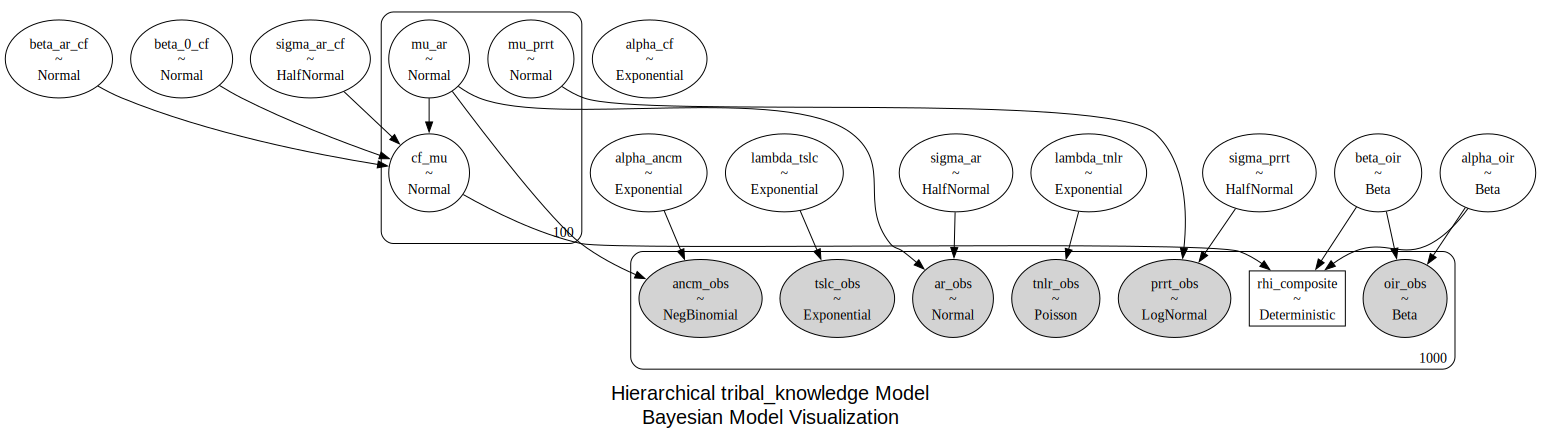

In [33]:
model_graph = pm.model_to_graphviz(tribal_knowledge)

# Customize the graph - Example changes
model_graph.attr(label='Hierarchical tribal_knowledge Model\nBayesian Model Visualization')
model_graph.attr(fontsize='20', color='blue', fontname="Helvetica")

# Node and Edge customizations
with model_graph.subgraph() as s:
    s.attr(rank='same')
    # Customize nodes
    s.node_attr.update(color='lightblue2', style='filled', fontname="Helvetica")
    # Customize edges
    s.edge_attr.update(color='gray', arrowsize='0.5')

# Render the graph 
model_graph


In [34]:
# Fiting the model - using nutpie for faster sampling

with tribal_knowledge:
    trace = pm.sample(500, tune=500, return_inferencedata=True, target_accept=0.95, nuts_sampler="nutpie")


ValueError: Random variables detected in the logp graph: {sigma_ar_cf}.
This can happen when DensityDist logp or Interval transform functions reference nonlocal variables,
or when not all rvs have a corresponding value variable.

### Results and Interpretation

This section guides you through extracting and interpreting the results of the hierarchical Bayesian model applied to programming language usage within an organisation. We'll focus on understanding the impact of various factors on language usage, visualise distributions across Owners and repositories, and identify potential outliers or areas of risk.

#### Identifying Outliers Based on Credible Intervals

Let's identify repositories whose observed language usage falls outside the credible intervals predicted by our model. These could be considered outliers.

In [ ]:
# Perform posterior predictive checks, which generate posterior predictive samples given a trace and a model:

with tribal_knowledge:
    ppc = pm.sample_posterior_predictive(trace)

In [ ]:
# Access the posterior_predictive group
posterior_predictive = ppc.posterior_predictive
summary_stats = az.summary(posterior_predictive, var_names=['language_count_obs'], hdi_prob=0.95)

# Assume byte_count is a list/array with the observed byte counts ordered as in your model
# This approach requires the model's indices to match the 'Repo_Lang_Key_codes' in 'df'
outliers = []

# Adding columns for CI lower, CI upper, and outlier flag directly to the df
df['CI_Lower'] = pd.NA
df['CI_Upper'] = pd.NA
df['Is_Outlier'] = False

for index, row in df.iterrows():
    repo_lang_key_code = row['Repo_Lang_Key_codes']
    ci_lower = summary_stats.loc[f"language_count_obs[{repo_lang_key_code}]", "hdi_2.5%"]
    ci_upper = summary_stats.loc[f"language_count_obs[{repo_lang_key_code}]", "hdi_97.5%"]
    
    # Update the DataFrame directly with CI values
    df.at[index, 'CI_Lower'] = ci_lower
    df.at[index, 'CI_Upper'] = ci_upper
    
    # Check if the current row's ByteCount is an outlier
    is_outlier = row['ByteCount'] < ci_lower or row['ByteCount'] > ci_upper
    df.at[index, 'Is_Outlier'] = is_outlier


print(f'Number of outlier Repo-Language combinations:, {df["Is_Outlier"].sum()}')

# Extracting detailed information for each outlier repository
# Now using the 'Is Outlier' flag directly instead of checking membership in the 'outliers' list
outlier_repos_info = df[df['Is_Outlier']].drop_duplicates(subset=['Unique_Repo'])

# Printing detailed information for outlier repositories including CI values
print("Outlier Repositories Detailed Information:")
print(outlier_repos_info[['Owner', 'Repository', 'Unique_Repo', 'ByteCount', 'CI_Lower', 'CI_Upper', 'Is_Outlier']])

In [ ]:
write_results = False
if write_results:
    ## Write file and trace to ./data/... with git commit-ID for checks
    commit_id = subprocess.check_output(["git", "rev-parse", "HEAD"]).strip().decode('utf-8')
    print(commit_id)
    
    # Write data with confidence regions:
    outlier_repos_info[['Owner', 'Repository', 'Unique_Repo', 'ByteCount', 'CI_Lower', 'CI_Upper', 'Is_Outlier']].to_csv(path_or_buf=f'data/outlier_language_repo_{commit_id}.csv', index=False)
    print("Outlier file written")
    
    # Write trace data
    # We use NetCDF format here as pickle is unsafe
    filename_with_commit = f"trace_data_{commit_id}.nc"
    trace.to_netcdf(f'data/{filename_with_commit}')
    print("Inference object written")

#### Deep Dive into Outliers
With the identified outliers, a deeper investigation into these specific repositories or Owners can provide insights into why they deviate from the model's expectations.
Lets look deeper into teh posterior distributions to figure out why this has been flagged.

In [ ]:
print(outlier_repos_info[['Unique_Repo', 'Is_Outlier']].value_counts())

In [ ]:

analysis = LanguagePosteriorAnalysis(df, ppc, {'Owner': 'Apache', 'Repository': 'zookeeper'})
outlier_report = analysis.calculate_outliers()
print(outlier_report)
# plot distributions 
analysis.plot_all_languages_posterior()


#### Example write up

Our comprehensive analysis of programming language byte counts within Owner_115_Repo_3, leveraging Hierarchical Bayesian Modelling (HBM), has illuminated various outlier scenarios across various programming languages. Notably, many languages, including Haskell, were identified as outliers based on their log-byte counts' 95% credible intervals. This widespread classification of outlier status points towards potential areas for model improvement and prompts a re-evaluation of our data generation and representation assumptions.

The observed log byte counts for several languages diverge markedly from the expected ranges predicted by our model. For example, Haskell and PowerShell exhibit notably lower log byte counts than anticipated, suggesting their utilization in the repository might be for highly specialized or concise functionalities not captured by our current model structure.

This analysis opens several avenues for deeper exploration:

- **Model Refinement:** The extensive identification of outliers underscores the need for model refinement. This could involve revisiting our model's assumptions, incorporating additional covariates that might explain the observed variability, or exploring more flexible distributions to better accommodate the diversity in programming language usage patterns.

- **Data Generation Compatibility:** The disparity between the model's expectations and the observed data highlights the importance of closely examining the data generation process. Ensuring that the process accurately reflects realistic programming language distributions and repository characteristics is crucial for model calibration.

- **Focused Investigation:** Languages' outlier status, particularly those with significant deviations like Haskell and PowerShell, invites focused investigation into their roles within the repository. Understanding the context and rationale behind their usage can provide valuable insights into Owner-specific practices and potential areas for optimization.

-  **Organizational Strategy:** Beyond model adjustments, these findings signal an opportunity to assess the broader organizational strategy regarding technology stack diversity, coding practices, and repository management. Identifying whether the observed patterns align with strategic goals or necessitate adjustments is essential for fostering a productive and innovative development environment.
This example highlights the importance of Hierarchical Bayesian Modelling (HBM) in detecting outliers and providing context in a multilevel data structure. By using this approach, we can improve our understanding of language usage patterns, which can inform strategic decisions around technology adoption, Owner management, and developer training.

Although our analysis revealed discrepancies between our model's predictions and observed data, it provides an opportunity for reflection and growth. We can enhance our understanding of programming language dynamics within our Owners by addressing these discrepancies through model refinement and strategic alignment. This will align our technological practices with organizational objectives, leading to informed decision-making and strategic development initiatives.

## EXTENSIONS

This is a very trivial modelling example and can be refined and updated to include far more variables to mutually understand a repo, i.e time since last commit for staleness, or active dependencies, total number of committers etc, etc. 

A novel and perhaps useful extension might be saving the trace of the model and creatin a streamlit app enabling ad hoc investigation, this could be especially powerful with the inclusion of the `do` operator that has now been introduced for what-if analysis (https://www.pymc.io/Owners/examples/en/latest/causal_inference/interventional_distribution.html)

